In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools
from dipole import dipole_map, spherical_to_cartesian

#### Quaia, selection function, CMB dipole

In [3]:
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
G = 20.5
quaia_fn = f'/scratch/aew492/quasars/catalogs/catalog_G{G}.fits'
map_quaia = tools.load_catalog_as_map(quaia_fn, frame='icrs')

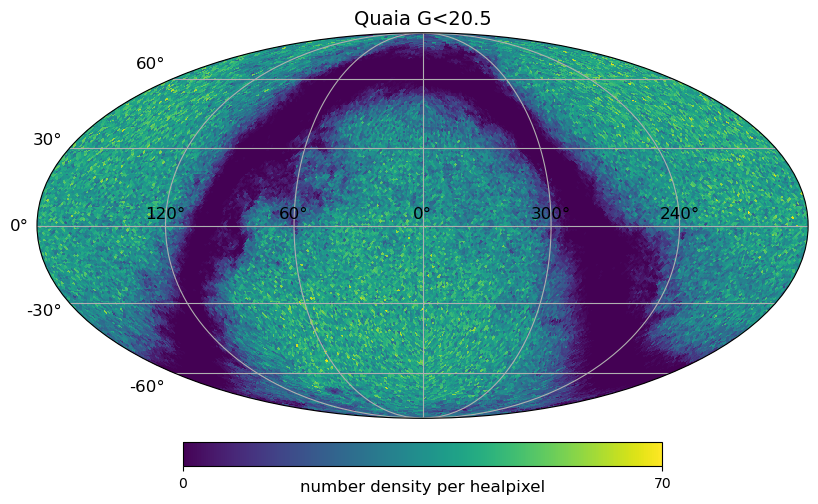

In [4]:
tools.plot_map(map_quaia, title=f'Quaia G<{G}', unit='number density per healpixel')

In [5]:
# redshift bins
tab_quaia = Table.read(quaia_fn, format='fits')
ras, decs, zs = tab_quaia['ra'], tab_quaia['dec'], tab_quaia['redshift_spz']

Text(0.5, 1.0, 'Redshift distribution')

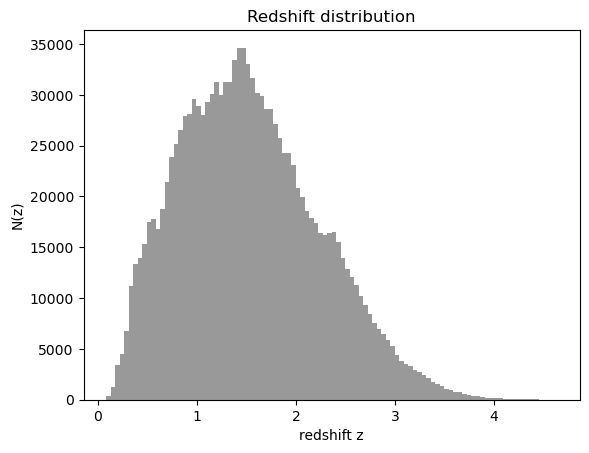

In [6]:
fig, ax = plt.subplots()
_, _, _ = ax.hist(zs, color='k', bins=100, alpha=0.4)
ax.set_xlabel('redshift z')
ax.set_ylabel('N(z)')
ax.set_title('Redshift distribution')

In [7]:
# get redshift bins
nbins = 3
nperbin = len(tab_quaia)//nbins
tab_quaia.sort('redshift_spz')
quaia_binned = [
    tab_quaia[i*nperbin:(i+1)*nperbin] for i in range(nbins)
]
zbins = np.append(0,
    [max(qsos['redshift_spz']) for qsos in quaia_binned]
)

In [8]:
zbins

array([0.        , 1.16403449, 1.793     , 4.63528728])

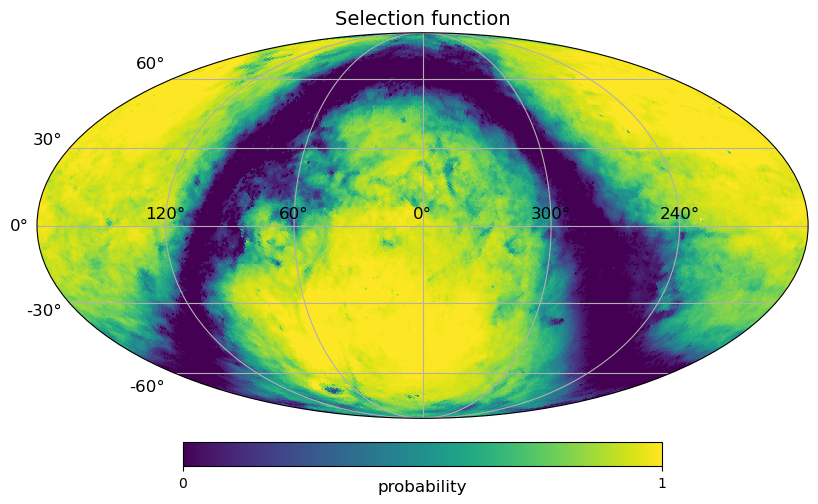

In [9]:
selfunc = tools.flatten_map(Table.read(
    f'/scratch/aew492/quasars/maps/selection_function_NSIDE{NSIDE}_G{G}.fits', format='fits'))
tools.plot_map(selfunc, title='Selection function', unit='probability')

In [10]:
cmb_dipamp = 0.007
cmb_dipdir = SkyCoord(264, 48, unit=u.deg, frame='galactic')
print(cmb_dipdir.icrs)
amps = np.array([0., *spherical_to_cartesian(r=cmb_dipamp,
                                             theta=np.pi/2-cmb_dipdir.icrs.dec.rad,
                                             phi=cmb_dipdir.icrs.ra.rad)])
expected_map = dipole_map(amps, NSIDE) # match NSIDE with Quaia map

<SkyCoord (ICRS): (ra, dec) in deg
    (167.78661173, -7.14538872)>


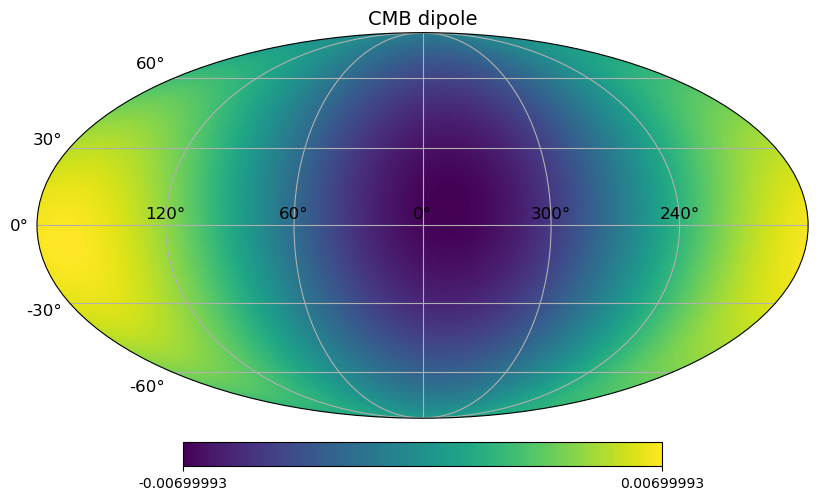

In [11]:
tools.plot_map(expected_map, title='CMB dipole')

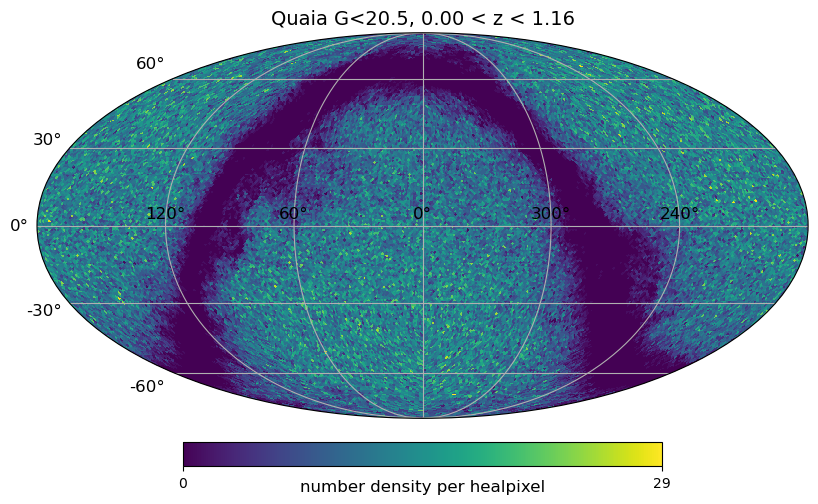

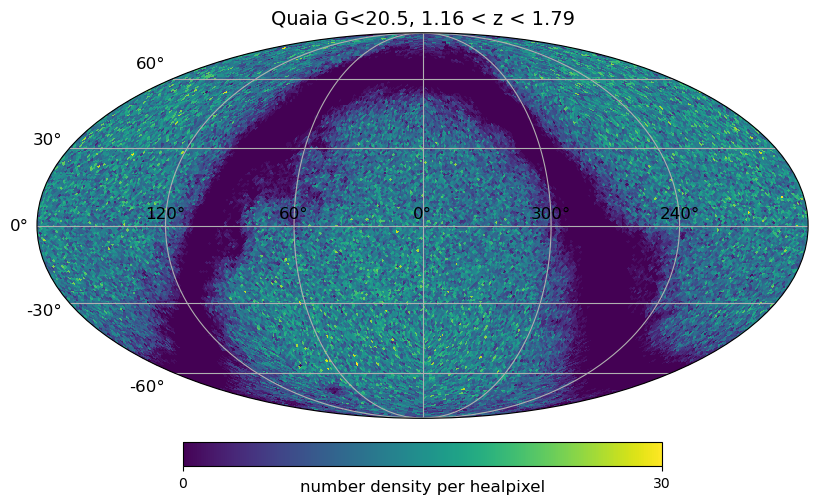

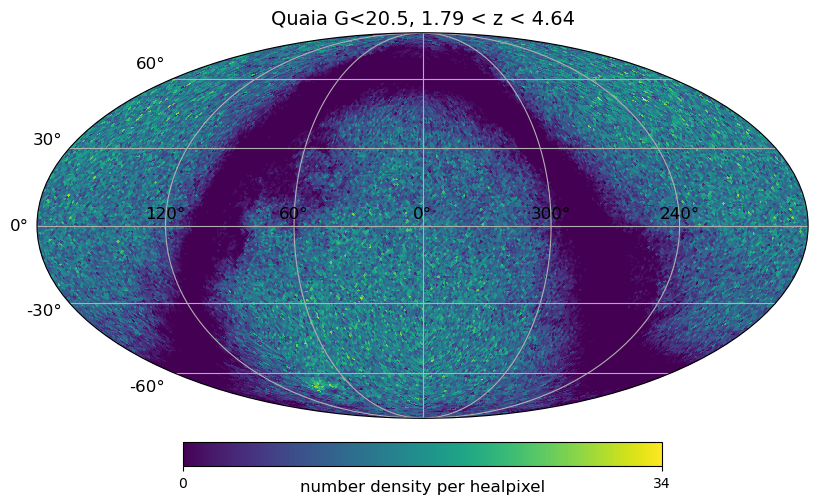

In [12]:
# format into healpy maps
quaia_maps = np.empty((nbins,NPIX))
for i, qsos in enumerate(quaia_binned):
    lon, lat = qsos['ra'], qsos['dec']
    pix_idx = hp.ang2pix(NSIDE, lon, lat, lonlat=True)
    map_quaia_ = np.bincount(pix_idx, minlength=hp.nside2npix(NSIDE))
    tools.plot_map(map_quaia_, title=f'Quaia G<{G}, {zbins[i]:.2f} < z < {zbins[i+1]:.2f}', unit='number density per healpixel')
    quaia_maps[i] = map_quaia_

### fit dipole in each redshift bin

In [13]:
# design matrix
A = selfunc[:,None] * np.column_stack((np.ones(NPIX), expected_map))  # [:,None] to make shapes agree
# covariances -> weight by completeness in each pixel
Cinv = np.diag(selfunc)

In [14]:
fit_results = np.empty((nbins,2))
for i, quaia_map in enumerate(quaia_maps):
    assert sum(np.isnan(quaia_map))==0
    b, m = tools.lstsq(quaia_map, A, Cinv)
    fit_results[i] = (b,m)
    print(f'{zbins[i]:.2f} < z < {zbins[i+1]:.2f}:\t mean = {b:.2f}\t slope = {m:.2f}\t ->\t amplitude = {m/b:.3f}')

0.00 < z < 1.16:	 mean = 13.33	 slope = 24.75	 ->	 amplitude = 1.857
1.16 < z < 1.79:	 mean = 13.66	 slope = 10.69	 ->	 amplitude = 0.783
1.79 < z < 4.64:	 mean = 14.08	 slope = 29.36	 ->	 amplitude = 2.086


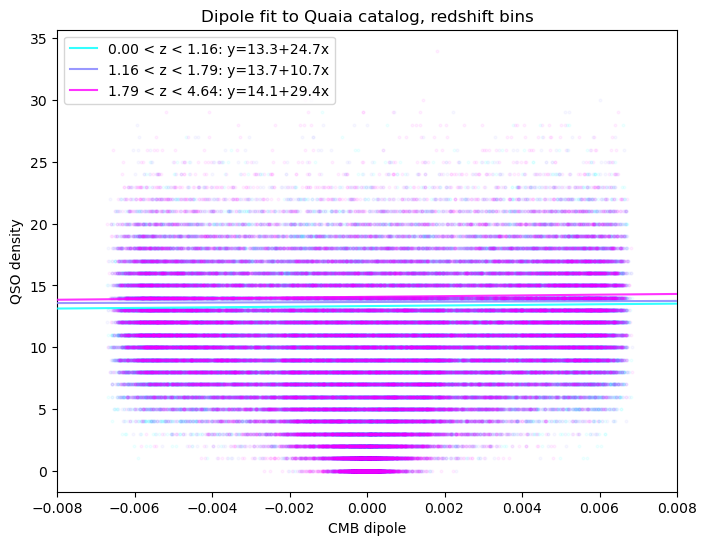

In [16]:
fig, ax = plt.subplots(figsize=(8,6))
colors = iter(mpl.cm.cool(np.linspace(0,1,nbins)))
for i, (b,m) in enumerate(fit_results):
    c = next(colors)
    x = np.linspace(-.008,.008)
    s = ax.scatter(A[:,1], quaia_maps[i], marker='.', s=15, ls='None', color=c, alpha=0.05)
    ax.plot(x, b+m*x, alpha=0.8, zorder=10+i, color=c,
            label=f'{zbins[i]:.2f} < z < {zbins[i+1]:.2f}: y={b:.1f}+{m:.1f}x')
ax.set_xlim((min(x),max(x)))
ax.set_xlabel('CMB dipole')
ax.set_ylabel('QSO density')
ax.set_title(f'Dipole fit to Quaia catalog, redshift bins')
ax.legend()